In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install caer canaro

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.5/809.5 kB 12.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 68.8 MB/s eta 0:00:00:00:010:01


In [7]:
import caer 
import os
import canaro
import cv2 as cv
import numpy as np
import gc

In [16]:
IMG_SIZE = (80,80)
channels = 1
char_path = r'../input/the-simpsons-characters-dataset/simpsons_dataset'

In [20]:
# Creating a character dictionary, sorting it in descending order
char_dict = {}
for char in os.listdir(char_path):
    char_dict[char] = len(os.listdir(os.path.join(char_path,char)))

# Sort in descending order
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('simpsons_dataset', 42),
 ('agnes_skinner', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [30]:
characters=[]
count=0
for i in char_dict:
    characters.append(i[0])
    count += 1
    if count >= 10:
        break
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

In [31]:

train = caer.preprocess_from_dir(char_path, characters, channels=channels, IMG_SIZE=IMG_SIZE, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 3.6740851402282715s
[INFO] At 1000 files
[INFO] 1454 files found in 1.1626057624816895s
[INFO] At 1000 files
[INFO] 1452 files found in 1.0600249767303467s
[INFO] At 1000 files
[INFO] 1354 files found in 0.7210540771484375s
[INFO] At 1000 files
[INFO] 1342 files found in 0.7383112907409668s
[INFO] At 1000 files
[INFO] 1291 files found in 0.5120282173156738s
[INFO] At 1000 files
[INFO] 1206 files found in 0.2772200107574463s
[INFO] At 1000 files
[INFO] 1194 files found in 0.1987462043762207s
[INFO] At 1000 files
[INFO] 1193 files found in 0.17992472648620605s
[INFO] At 1000 files
[INFO] 1079 files found in 0.0051882266998291016s
----------------------------------------------
[INFO] 13811 files preprocessed! Took 2m 32s


In [32]:
len(train)

13811

In [33]:
features,labels=caer.sep_train(train,IMG_SIZE=IMG_SIZE)

In [35]:
from tensorflow.keras.utils import to_categorical
featureSet = caer.normalize(features)
labels = to_categorical(labels, len(characters))

In [38]:
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet, labels, val_ratio=.2)

In [39]:
del train
del featureSet
del labels 
gc.collect()

0

In [79]:
BATCH_SIZE = 32
EPOCHS = 10
# Image data generator (introduces randomness in network ==> better accuracy)
datagen = canaro.generators.imageDataGenerator()
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [121]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization

output_dim = 10
w, h = IMG_SIZE[:2]

model = Sequential()

# First Convolutional Block
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(w, h, channels)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Block
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# Third Convolutional Block
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully Connected Layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(output_dim, activation='softmax'))


In [122]:
model.summary()

Model: "sequential_60"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_360 (Conv2D)             │ (None, 80, 80, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 80, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_361 (Conv2D)             │ (None, 78, 78, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 78, 78, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_180               │ (None, 39, 39, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_362 (Conv2D)             │ (None, 39, 39, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 39, 39, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_363 (Conv2D)             │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_181               │ (None, 18, 18, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_227 (Dropout)           │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_364 (Conv2D)             │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_365 (Conv2D)             │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_182               │ (None, 8, 8, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_60 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_228 (Dropout)           │ (None, 512)            │             

 Total params: 4,490,218 (17.13 MB)

 Trainable params: 4,488,298 (17.12 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [123]:
from tensorflow.keras.optimizers import SGD
optimizer = SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [124]:
# Training the model

from tensorflow.keras.callbacks import LearningRateScheduler
callbacks_list = [LearningRateScheduler(canaro.lr_schedule)]
training = model.fit(train_gen,
                    steps_per_epoch=len(x_train)//BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(x_val,y_val),
                    validation_steps=len(y_val)//BATCH_SIZE,
                    callbacks = callbacks_list)

Epoch 1/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 22s 41ms/step - accuracy: 0.2510 - loss: 2.5377 - val_accuracy: 0.2565 - val_loss: 2.4643 - learning_rate: 0.0100
Epoch 2/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5625 - loss: 1.6556 - val_accuracy: 0.2507 - val_loss: 2.4790 - learning_rate: 0.0100
Epoch 3/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.3840 - loss: 1.9488 - val_accuracy: 0.2066 - val_loss: 3.7286 - learning_rate: 0.0100
Epoch 4/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4688 - loss: 1.4374 - val_accuracy: 0.1834 - val_loss: 4.0503 - learning_rate: 0.0100
Epoch 5/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.4746 - loss: 1.6848 - val_accuracy: 0.4425 - val_loss: 1.8904 - learning_rate: 0.0100
Epoch 6/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6562 - loss: 1.1625 - val_accuracy: 0.4349 - val_loss: 1.8758 - learning_rate: 0.0100
Epoch 7/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.5459 - loss: 1.43

In [125]:
characters

['homer_simpson',
 'ned_flanders',
 'moe_szyslak',
 'lisa_simpson',
 'bart_simpson',
 'marge_simpson',
 'krusty_the_clown',
 'principal_skinner',
 'charles_montgomery_burns',
 'milhouse_van_houten']

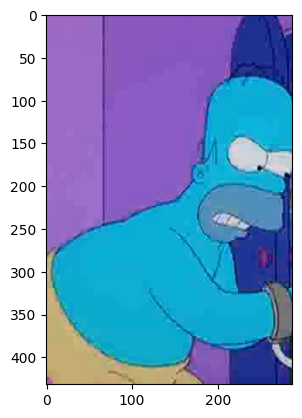

In [133]:
import matplotlib.pyplot as plt
test_path = r'/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/homer_simpson/pic_0004.jpg'

img = cv.imread(test_path)

plt.imshow(img)
plt.show()

In [134]:
def prepare(image):
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image = cv.resize(image, IMG_SIZE)
    image = caer.reshape(image, IMG_SIZE, 1)
    return image

In [135]:
predictions = model.predict(prepare(img))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [136]:
print(characters[np.argmax(predictions[0])])

ned_flanders
